# 使用块的网络（VGG）


虽然AlexNet证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络。
在下面的几个章节中，我们将介绍一些常用于设计深层神经网络的启发式概念。

与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络架构的设计也逐渐变得更加抽象。研究人员开始从单个神经元的角度思考问题，发展到整个层，现在又转向块，重复层的模式。

使用块的想法首先出现在牛津大学的[视觉几何组（visual geometry group）](http://www.robots.ox.ac.uk/~vgg/)的*VGG网络*中。通过使用循环和子程序，可以很容易地在任何现代深度学习框架的代码中实现这些重复的架构。



## (**VGG块**)

经典卷积神经网络的基本组成部分是下面的这个序列：

1. 带填充以保持分辨率的卷积层；
1. 非线性激活函数，如ReLU；
1. 汇聚层，如最大汇聚层。

而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。在最初的VGG论文中 `Simonyan.Zisserman.2014`，作者使用了带有$3\times3$卷积核、填充为1（保持高度和宽度）的卷积层，和带有$2 \times 2$汇聚窗口、步幅为2（每个块后的分辨率减半）的最大汇聚层。在下面的代码中，我们定义了一个名为`vgg_block`的函数来实现一个VGG块。

In [15]:
import torch
from torch import nn


import sys
sys.path.append("..")
import d2lzh_pytorch.torch as d2l

In [24]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = list()
    
    # (1, 64) 
    '''
    num_convs:    遍历多少次
    out_channels: 输出通道数
    '''
    
    conv2d_count = 1
    for _ in range(num_convs):
        print("vgg_block内部: %s" % conv2d_count)
        # 卷积层
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        # 激活函数
        layers.append(nn.ReLU())
        
        in_channels = out_channels
        
        conv2d_count += 1
        pass
    
    # 兜底, 最大池化层
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [51]:

# num_convs 多少个(Conv2d+ReLu), out_channels
# conv_arch = ((1, 64), 
#              (1, 128), 
#              (2, 256), 
#              (2, 512), 
#              (2, 512)
#             )

conv_arch = ((1, 64), 
             (2, 128), 
             (3, 256), 
             (4, 512), 
             (4, 512)
            )

下面的代码实现了VGG-11。可以通过在`conv_arch`上执行for循环来简单实现。


In [52]:
def vgg(conv_arch):
    
    conv_blks = []
    in_channels = 1
    
    # 循环添加-卷积层
    vgg_block_count = 0
    for (num_convs, out_channels) in conv_arch:
        print("%s n_convs: %s, out: %s" % (vgg_block_count, num_convs, out_channels))
        # 添加vgg_block块
        vgg_black_item = vgg_block(num_convs, in_channels, out_channels)
        conv_blks.append(vgg_black_item)
        
        # 重置通道数
        in_channels = out_channels
        
        vgg_block_count += 1
        pass

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )


net = vgg(conv_arch)

0 n_convs: 1, out: 64
vgg_block内部: 1
1 n_convs: 2, out: 128
vgg_block内部: 1
vgg_block内部: 2
2 n_convs: 3, out: 256
vgg_block内部: 1
vgg_block内部: 2
vgg_block内部: 3
3 n_convs: 4, out: 512
vgg_block内部: 1
vgg_block内部: 2
vgg_block内部: 3
vgg_block内部: 4
4 n_convs: 4, out: 512
vgg_block内部: 1
vgg_block内部: 2
vgg_block内部: 3
vgg_block内部: 4


接下来，我们将构建一个高度和宽度为224的单通道数据样本，以[**观察每个层输出的形状**]。


In [56]:
X = torch.randn(size=(1, 1, 224, 224))
X

tensor([[[[-0.5347, -0.9215, -0.4171,  ...,  0.8849,  1.0398, -1.6988],
          [ 0.1542, -0.1201, -0.4964,  ...,  1.2008,  1.2640,  1.3067],
          [-0.4512, -0.1142, -1.0719,  ..., -1.3176,  0.9114, -0.1440],
          ...,
          [-0.7210,  1.0850,  0.1005,  ..., -0.0138,  0.3517, -3.2810],
          [ 0.8292, -0.0203, -0.6726,  ...,  0.5409,  0.7579,  0.0701],
          [-1.1277, -0.3069, -2.0943,  ..., -0.3550,  0.0185,  0.5864]]]])

In [57]:
for blk in net:
    print("blk: ", blk)
    X = blk(X)
    # print(X, '\r\n')
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

blk:  Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential output shape:	 torch.Size([1, 64, 112, 112])
blk:  Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential output shape:	 torch.Size([1, 128, 56, 56])
blk:  Sequential(
  (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential output shape:	 torch.Size([1, 256, 28, 28]

正如从代码中所看到的，我们在每个块的高度和宽度减半，最终高度和宽度都为7。最后再展平表示，送入全连接层处理。

## 训练模型

[**由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络**]，足够用于训练Fashion-MNIST数据集。


In [59]:
ratio = 4

small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]

# num_convs, out_channels
# small_conv_arch

In [60]:
net = vgg(small_conv_arch)

net

0 n_convs: 1, out: 16
vgg_block内部: 1
1 n_convs: 2, out: 32
vgg_block内部: 1
vgg_block内部: 2
2 n_convs: 3, out: 64
vgg_block内部: 1
vgg_block内部: 2
vgg_block内部: 3
3 n_convs: 4, out: 128
vgg_block内部: 1
vgg_block内部: 2
vgg_block内部: 3
vgg_block内部: 4
4 n_convs: 4, out: 128
vgg_block内部: 1
vgg_block内部: 2
vgg_block内部: 3
vgg_block内部: 4


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Co

除了使用略高的学习率外，[**模型训练**]过程与`sec_alexnet`中的AlexNet类似。


In [61]:
lr = 0.05
num_epochs = 5
batch_size = 128

# 加载数据
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.312, train acc 0.883, test acc 0.890
1017.7 examples/sec on cuda:0


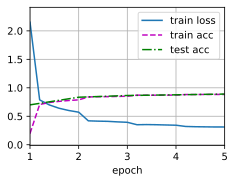

In [62]:

# 训练
d2l.train_ch6(net, train_iter, test_iter, 
              num_epochs, 
              lr, 
              d2l.try_gpu()
             )